In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d salmaneunus/rock-classification

rock-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('/content/rock-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [1]:
import os
import shutil

import PIL
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import pandas as pd
import cv2

import imghdr # Check the type of images

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten , Conv2D , MaxPooling2D , Dropout, Conv3D, MaxPooling3D
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

C:\Users\Sanket\AppData\Local\Temp\ipykernel_8776\3754453050.py:17: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr # Check the type of images


In [147]:
# !rm /content/Dataset/Sedimentary/Sandstone -r

In [12]:
!rm copy_rocks --r

In [2]:
shutil.copytree("D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\Rock_dataset", "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks")

'D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks'

In [3]:
home_data = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks"
main_labels = os.listdir(home_data)
all_labels = []

In [4]:
mainAndSubLebels = dict() # Class : Labels
for i in main_labels:
    mainAndSubLebels[i] = os.listdir(os.path.join(home_data,i))

mainAndSubLebels

{'Igneous': ['Basalt', 'Granite'],
 'Metamorphic': ['Marble', 'Quartzite'],
 'Sedimentary': ['Coal', 'Limestone', 'Sandstone']}

In [5]:
label_and_num_img = dict() # Label : #Images, e.g. Quartzite : 477
total_num_of_images = 0

for Mainclass in mainAndSubLebels.keys():
  for label in mainAndSubLebels[Mainclass]:
    total_for_each_label = len(os.listdir(os.path.join(home_data, Mainclass, label)))
    label_and_num_img[label] = total_for_each_label
    total_num_of_images = total_num_of_images + total_for_each_label
    print(f"The total number of images in {Mainclass}/{label} = ({total_for_each_label})")

  print("-----------------------------")

print(f"The Total Number of Images = {total_num_of_images}")


The total number of images in Igneous/Basalt = (44)
The total number of images in Igneous/Granite = (101)
-----------------------------
The total number of images in Metamorphic/Marble = (387)
The total number of images in Metamorphic/Quartzite = (477)
-----------------------------
The total number of images in Sedimentary/Coal = (369)
The total number of images in Sedimentary/Limestone = (164)
The total number of images in Sedimentary/Sandstone = (323)
-----------------------------
The Total Number of Images = 1865


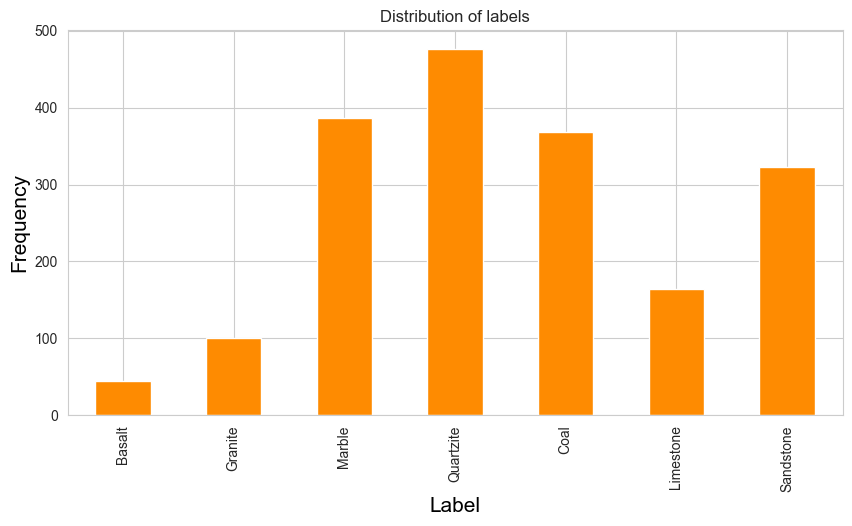

In [6]:
plt.figure(figsize = (10,5))
sns.set_style('whitegrid')

pd.Series(label_and_num_img).plot.bar(color = '#fe8b01')
plt.title("Distribution of labels")
plt.xlabel('Label', fontsize = 15, color = 'black')
plt.ylabel('Frequency', fontsize = 15, color = 'black')
plt.show()

In [7]:
# Getting Information of The Images

def get_info(mainAndSubLabels):
  df = dict()
  types = list()
  widths = list()
  heights = list()
  paths = list()
  labels = list()

  for Mainclass in mainAndSubLebels.keys():
    for label in mainAndSubLebels[Mainclass]:
      all_label_images = os.listdir(os.path.join(home_data, Mainclass, label))
      for image in all_label_images:
        image_path = os.path.join(home_data, Mainclass, label,image) # Get the path of an image
        img = Image.open(image_path)
        width, height = img.size # #extract width and height from output tuple

        types.append(imghdr.what(image_path)) # Add the type of an image
        widths.append(width) # Add the width of the image
        heights.append(height) # Height of the image
        paths.append(image_path) # Add the path of an image
        labels.append(label) # Add the label of an image

  df["Path"] = paths
  df["Type"] = types
  df["Width"] = widths
  df["Height"] = heights
  df["Label"] = labels

  return df

In [8]:
df = get_info(mainAndSubLebels)
df = pd.DataFrame(df) # Convert To DataFrame
df.head()

,Path,Type,Width,Height,Label
0,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,webp,250,167,Basalt
1,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,194,259,Basalt
2,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,2016,1512,Basalt
3,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,400,300,Basalt
4,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,1600,1600,Basalt


In [9]:
## Record Currnt labels. We'll use them later :)
old_labels = dict(df['Label'].value_counts())

In [10]:
def processor(df):
    counter = 0
    for image_path in df['Path']:
        try:
            fileobject = open(image_path, 'rb')
            is_ok = tf.compat.as_bytes('JFIF') in fileobject.peek(10)

        finally:
            fileobject.close()
            if not is_ok:
                counter += 1
                df.drop(df.index[df['Path'] == image_path], inplace=True)
                os.remove(image_path)

    print(f"The number of corrupted images is {counter}")

    return df

In [11]:
df = processor(df)

The number of corrupted images is 99


In [12]:
counter = 0
for image_path in df["Path"]:
    extension = image_path.split(".")[-1]
    if extension == 'jfif' or extension == 'webp'or extension == 'png':
        df.drop(df.index[df['Path'] == image_path], inplace=True)
        os.remove(image_path)


print(counter)

0


In [13]:
def dhash(image, hashSize=8):
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	resized = cv2.resize(gray, (hashSize + 1, hashSize))
	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]
	# convert the difference image to a hash and return it
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

hashes = {}
for Mainclass in mainAndSubLebels.keys():
    for label in mainAndSubLebels[Mainclass]:
        all_label_images = os.listdir(os.path.join(home_data, Mainclass, label))
    for image in all_label_images:
        image_path = os.path.join(home_data, Mainclass, label,image)
        image = cv2.imread(image_path)
        h = dhash(image)

        # grab all image paths with that hash, add the current image
        # path to it, and store the list back in the hashes dictionary
        p = hashes.get(h, [])
        p.append(image_path)
        hashes[h] = p

duplicates = []
for [hash, image_paths] in hashes.items():
    if len(image_paths) > 1:
        duplicates.append(image_paths)

In [14]:
# Remove Duplicates
for i in duplicates:
    if len(i) > 2:
        for j in i[:-1]:
            os.remove(j)
            df.drop(df.index[df['Path'] == j], inplace=True)
    else:
        os.remove(i[0])
        df.drop(df.index[df['Path'] == i[0]], inplace=True)

In [15]:
new_labels = dict(df["Label"].value_counts())
num_of_labels = 7
for i in new_labels.keys():
    for j in old_labels.keys():
        if i == j:
            removed = old_labels[i] - new_labels[j]
            print(f"Num of removed duplicates for {i} was ({removed})")

Num of removed duplicates for Quartzite was (4)
Num of removed duplicates for Marble was (3)
Num of removed duplicates for Coal was (15)
Num of removed duplicates for Sandstone was (6)
Num of removed duplicates for Limestone was (31)
Num of removed duplicates for Granite was (36)
Num of removed duplicates for Basalt was (9)


In [16]:
num = 0
igneous = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Igneous"
for i in os.listdir(igneous):
    for j in os.listdir(os.path.join(igneous, i)):
        image_path = os.path.join(igneous, i, j)
        os.rename(image_path, os.path.join(igneous, i, f"{i}{num}.jpg"))
        num += 1

In [18]:
!rm New_Igneous_Basalt -r

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
from keras.preprocessing.image import ImageDataGenerator

os.mkdir("D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Igneous_Basalt")

img_dir_path = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Igneous"
save_dir_path = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Igneous_Basalt"

datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range =(0.5, 1.5),
                             shear_range = .2,
                             zoom_range = .2,
                             horizontal_flip=True,
                             vertical_flip = True
                             )

data_generator = datagen.flow_from_directory(
    img_dir_path,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=64,
    save_to_dir=save_dir_path,
    classes = ["Basalt"],
    class_mode="binary",
    save_prefix="augmented",
    save_format="jpg")

for i in range(10):
    data_generator.next()

Found 35 images belonging to 1 classes.


In [30]:
!rm New_Igneous_Granite -r

In [20]:
from keras.preprocessing.image import ImageDataGenerator

os.mkdir("D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Igneous_Granite")

img_dir_path = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Igneous"
save_dir_path = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Igneous_Granite"

datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range =(0.5, 1.5),
                             shear_range = .2,
                             zoom_range = .2,
                             horizontal_flip=True,
                             vertical_flip = True
                             )

data_generator = datagen.flow_from_directory(
    img_dir_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    save_to_dir=save_dir_path,
    classes = ["Granite"],
    class_mode="binary",
    save_prefix="augmented",
    save_format="jpg")

for i in range(10):
    data_generator.next()

Found 65 images belonging to 1 classes.


In [32]:
!rm New_Sedimentary_Limestone -r

In [21]:
from keras.preprocessing.image import ImageDataGenerator

os.mkdir("D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Sedimentary_Limestone")

img_dir_path = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Sedimentary"

save_dir_path = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Sedimentary_Limestone"


datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range =(0.5, 1.5),
                             shear_range = .2,
                             zoom_range = .2,
                             horizontal_flip=True,
                             vertical_flip = True
                             )

data_generator = datagen.flow_from_directory(
    img_dir_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    save_to_dir=save_dir_path,
    classes = ["Limestone"],
    class_mode="binary",
    save_prefix="augmented",
    save_format="jpg")

for i in range(10):
    data_generator.next()

Found 133 images belonging to 1 classes.


In [23]:
New_Igneous_Basalt = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Igneous_Basalt"
New_Igneous_Granite = "D:\\STUDY\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Igneous_Granite"


New_Sedimentary_Limestone = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Sedimentary_Limestone"

for image_name in os.listdir(New_Igneous_Basalt):
    image_source = os.path.join(New_Igneous_Basalt, image_name)
    shutil.copy(image_source, "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Igneous\\Basalt")

for image_name in os.listdir(New_Igneous_Granite):
    image_source = os.path.join(New_Igneous_Granite, image_name)
    shutil.copy(image_source, "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Igneous\\Granite")

for image_name in os.listdir(New_Sedimentary_Limestone):
    image_source = os.path.join(New_Sedimentary_Limestone, image_name)
    shutil.copy(image_source, "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Sedimentary\\Limestone")

In [24]:
New_Igneous_Basalt = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Igneous_Basalt"
New_Igneous_Granite = "D:\\STUDY\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Igneous_Granite"


New_Sedimentary_Limestone = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\New_Sedimentary_Limestone"

for image_name in os.listdir(New_Igneous_Basalt):
    image_source = os.path.join(New_Igneous_Basalt, image_name)
    shutil.copy(image_source, "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Igneous\\Basalt")

for image_name in os.listdir(New_Igneous_Granite):
    image_source = os.path.join(New_Igneous_Granite, image_name)
    shutil.copy(image_source, "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Igneous\\Granite")

for image_name in os.listdir(New_Sedimentary_Limestone):
    image_source = os.path.join(New_Sedimentary_Limestone, image_name)
    shutil.copy(image_source, "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\Sedimentary\\Limestone")

copy_home_data = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks"
label_and_num_img = dict() # Label : #Images, e.g. Quartzite : 477
total_num_of_images = 0

for Mainclass in mainAndSubLebels.keys():
  for label in mainAndSubLebels[Mainclass]:
    total_for_each_label = len(os.listdir(os.path.join(copy_home_data, Mainclass, label)))
    label_and_num_img[label] = total_for_each_label
    total_num_of_images = total_num_of_images + total_for_each_label
    print(f"The total number of images in {Mainclass}/{label} = ({total_for_each_label})")

  print("-----------------------------")

print(f"The Total Number of Images = {total_num_of_images}")

The total number of images in Igneous/Basalt = (385)
The total number of images in Igneous/Granite = (390)
-----------------------------
The total number of images in Metamorphic/Marble = (384)
The total number of images in Metamorphic/Quartzite = (473)
-----------------------------
The total number of images in Sedimentary/Coal = (354)
The total number of images in Sedimentary/Limestone = (596)
The total number of images in Sedimentary/Sandstone = (317)
-----------------------------
The Total Number of Images = 2899


In [25]:
import cv2
import matplotlib.pyplot as plt

def sharpen_image(img_path):
    img = cv2.imread(img_path) #read in the image

    #convert to grayscale for easier manipulation
    # sharpened = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #apply the sharpening kernel to the grayscale image
    sharpened = cv2.filter2D(img, -1, kernel=(0,0,0,0,9,0,0,0,0))

    #display original and sharpened images side by side for comparison
    #plt.figure()
    #plt.subplot(121),plt.imshow(gray,cmap='gray')
    #plt.title('Original'), plt.xticks([]), plt.yticks([])


    #plt.subplot(122),plt.imshow(sharpened,cmap='gray')
    #plt.title('Sharpened'), plt.xticks([]), plt.yticks([])
    #plt.show()

    return sharpened

In [37]:
# classes = {
#     "Basalt":"/content/copy_rocks/Igneous/Basalt",
#     "Granite":"/content/copy_rocks/Igneous/Granite",
#     "Marble":"/content/copy_rocks/Metamorphic/Marble",
#     "Quartzite":"/content/copy_rocks/Metamorphic/Quartzite",
#     "Coal":"/content/copy_rocks/Sedimentary/Coal",
#     "Limestone":"/content/copy_rocks/Sedimentary/Limestone",
#     "Sandstone":"/content/copy_rocks/Sedimentary/Sandstone"

# }


# for [clas,path] in classes.items():

#      for i in os.listdir(path):
#         image_path = os.path.join(path, i)
#         img = sharpen_image(image_path)
#         cv2.imwrite(os.path.join(path, f"sharpened_{i}"), img )
#         # Delete the old image from the folder
#         os.remove(os.path.join(path, i))

In [26]:
modified_df = get_info(mainAndSubLebels)
modified_df = pd.DataFrame(modified_df) # Convert To DataFrame
modified_df.head()

,Path,Type,Width,Height,Label
0,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
1,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
2,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
3,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
4,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt


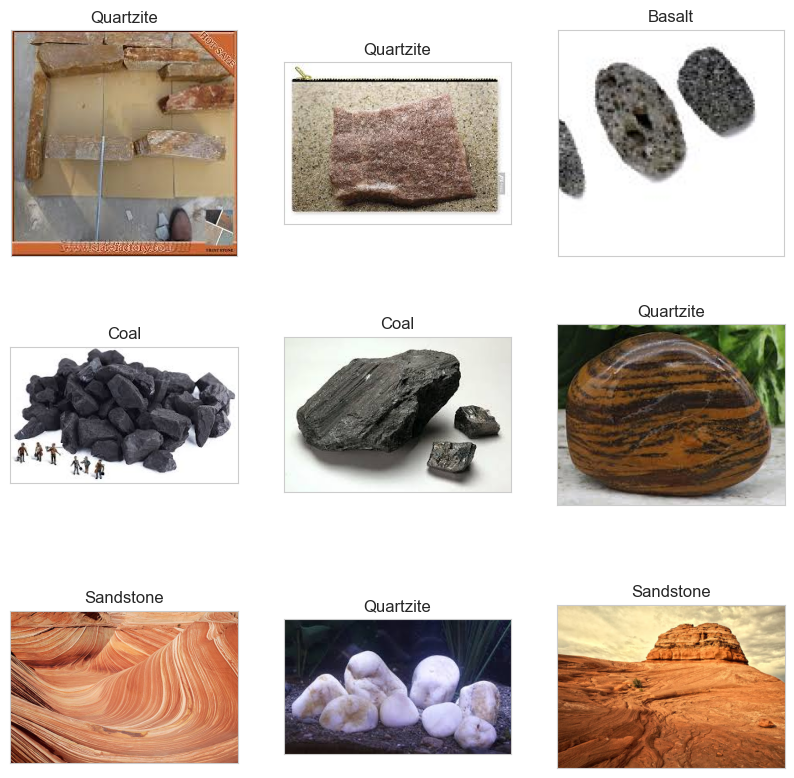

In [27]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop over the rows and columns of the figure
for i in range(3):
    for j in range(3):
        # Get a random row from the dataframe
        row = modified_df.sample().iloc[0]

        # Get the image path and label from the row
        img_path = row["Path"]
        img_label = row["Label"]

        # Read the image using OpenCV
        img = cv2.imread(img_path)

        # Convert the image from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image on the corresponding axis
        axes[i, j].imshow(img)

        # Set the title of the axis as the label
        axes[i, j].set_title(img_label)

        # Remove the ticks and labels from the axis
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Show the figure
plt.show()

In [28]:
# Find the label that has the least number of rows
min_label = modified_df["Label"].value_counts().idxmin()

# Find the number of rows for that label
min_count = modified_df["Label"].value_counts().min()

# Create an empty dataframe to store the equalized rows
df_equal = pd.DataFrame()

# Loop over the unique labels in the dataframe
for label in modified_df["Label"].unique():
    # Get a random sample of rows for each label with the same size as the minimum count
    df_sample = modified_df[modified_df["Label"] == label].sample(min_count)

    # Append the sample to the equalized dataframe
    df_equal = pd.concat([df_equal, df_sample])

# Print the equalized dataframe
df_equal

,Path,Type,Width,Height,Label
298,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
344,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
207,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
202,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
129,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,128,128,Basalt
...,...,...,...,...,...
2783,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,612,254,Sandstone
2773,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,612,408,Sandstone
2710,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,612,408,Sandstone
2619,D:\STUDY\MachinLearning\CP\Multi-Class-Image-C...,jpeg,612,408,Sandstone


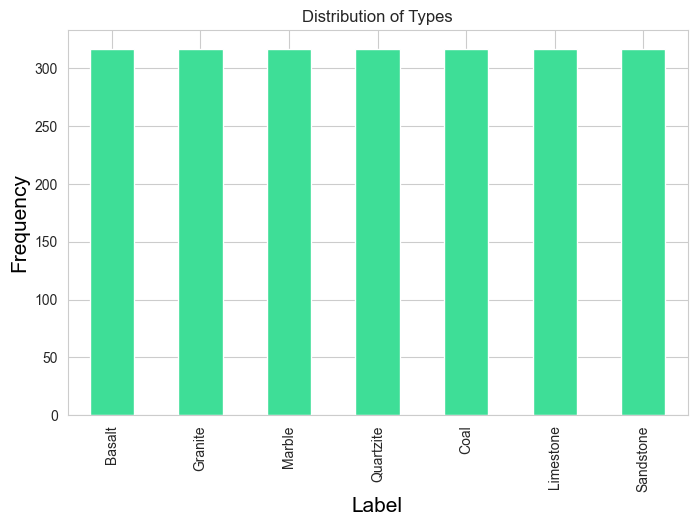

In [29]:
plt.figure(figsize = (8,5))
df_equal["Label"].value_counts().plot.bar(color = '#3ede97')
plt.title("Distribution of Types")
plt.xlabel('Label', fontsize = 15, color = 'black')
plt.ylabel('Frequency', fontsize = 15, color = 'black')
plt.show()

In [125]:
!rm train_dst -r
!rm test_dst -r

In [30]:
train_df, test_df = train_test_split(df_equal, test_size=0.2)
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Basalt')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Coal')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Sandstone')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Granite')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Marble')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Limestone')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Quartzite')

os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Basalt')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Coal')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Sandstone')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Granite')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Marble')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Limestone')
os.makedirs('D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Quartzite')

train_classes = {
    "Basalt":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Basalt",
    "Granite":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Coal",
    "Marble":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Sandstone",
    "Quartzite":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Granite",
    "Coal":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Marble",
    "Limestone":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Limestone",
    "Sandstone":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst\\Quartzite"

}

test_classes = {
    "Basalt":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Basalt",
    "Granite":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Coal",
    "Marble":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Sandstone",
    "Quartzite":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Granite",
    "Coal":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Marble",
    "Limestone":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Limestone",
    "Sandstone":"D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst\\Quartzite"

}

for label in train_classes.keys():
    if label == "Basalt":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = train_classes[label]
            shutil.copy(path, image_source)

    elif label == "Coal":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = train_classes[label]
            shutil.copy(path, image_source)

    elif label == "Sandstone":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = train_classes[label]
            shutil.copy(path, image_source)

    elif label == "Granite":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = train_classes[label]
            shutil.copy(path, image_source)

    elif label == "Marble":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = train_classes[label]
            shutil.copy(path, image_source)

    elif label == "Limestone":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = train_classes[label]
            shutil.copy(path, image_source)

    elif label == "Quartzite":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = train_classes[label]
            shutil.copy(path, image_source)

# Test Classes
for label in test_classes.keys():
    if label == "Basalt":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = test_classes[label]
            shutil.copy(path, image_source)

    elif label == "Coal":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = test_classes[label]
            shutil.copy(path, image_source)

    elif label == "Sandstone":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = test_classes[label]
            shutil.copy(path, image_source)

    elif label == "Granite":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = test_classes[label]
            shutil.copy(path, image_source)

    elif label == "Marble":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = test_classes[label]
            shutil.copy(path, image_source)

    elif label == "Limestone":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = test_classes[label]
            shutil.copy(path, image_source)

    elif label == "Quartzite":
        for path in train_df[train_df["Label"] == label]["Path"]:
            image_source = test_classes[label]
            shutil.copy(path, image_source)
train_dst = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\train_dst"
test_dst = "D:\\STUDY\\MachinLearning\\CP\\Multi-Class-Image-Classification\\copy_rocks\\test_dst"
# Load training and validation sets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dst,validation_split=0.2,
    subset='training',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dst,validation_split=0.2,
    subset='validation',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dst,
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)


Found 1775 files belonging to 7 classes.
Using 1420 files for training.
Found 1775 files belonging to 7 classes.
Using 355 files for validation.
Found 1775 files belonging to 7 classes.


In [63]:
# model = Sequential()
# model.add(Rescaling(1./255 ,input_shape=(224,224,3)))
# model.add(Conv2D(16, 3, padding='same', activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(32, 3, padding='same', activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(64, 3, padding='same', activation='relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.5)) # Add dropout layer
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(7 , activation = 'softmax'))
# model.summary()
# model.compile(loss='categorical_crossentropy',optimizer='adam' , metrics=['accuracy'])
# # Set callback functions to early stop training
# mycallbacks = [EarlyStopping(monitor='val_loss', patience=5,  restore_best_weights=True)]
# model_hist = model.fit(train_ds,validation_data=valid_ds, epochs=50 , callbacks=mycallbacks )
# model.evaluate(test_ds)

In [45]:
# model.compile(loss='categorical_crossentropy',optimizer='adam' , metrics=['accuracy'])

In [46]:
# # Set callback functions to early stop training
# mycallbacks = [EarlyStopping(monitor='val_loss', patience=5,  restore_best_weights=True)]
# model_hist = model.fit(train_ds,validation_data=valid_ds, epochs=200 , callbacks=mycallbacks )

In [47]:
# model.evaluate(test_ds)

In [48]:
# history = model.fit(train_ds,epochs=10,validation_data=valid_ds)

In [31]:
import cv2

In [32]:
mainAndSubLebels = dict() # Class : Labels
for i in main_labels:
    mainAndSubLebels[i] = os.listdir(os.path.join(home_data,i))

mainAndSubLebels

{'Igneous': ['Basalt', 'Granite'],
 'Metamorphic': ['Marble', 'Quartzite'],
 'Sedimentary': ['Coal', 'Limestone', 'Sandstone']}

In [33]:
import os

mainAndSubLabels = []  # List to store sub-labels

for main_label in main_labels:
    sub_labels = os.listdir(os.path.join(home_data, main_label))
    mainAndSubLabels.extend(sub_labels)

print(mainAndSubLabels)

['Basalt', 'Granite', 'Marble', 'Quartzite', 'Coal', 'Limestone', 'Sandstone']


In [129]:
test_img = cv2.imread('/content/Dataset/Sedimentary/Coal/10.jpg')

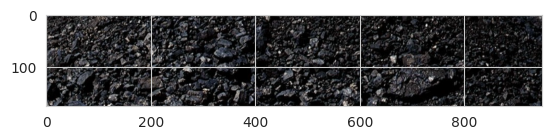

In [130]:
plt.imshow(test_img)

In [131]:
test_img.shape

(175, 949, 3)

In [132]:
test_img = cv2.resize(test_img,(224,224))

In [133]:
test_input = test_img.reshape((1,224,224,3))

In [84]:
# # Load training and validation sets
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_dst,validation_split=0.2,
#     subset='training',
#     labels='inferred',
#     label_mode='categorical',
#     image_size=[224, 224],
#     seed=123,
#     interpolation='nearest',
#     batch_size=64,
#     shuffle=True,
# )
# valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_dst,validation_split=0.2,
#     subset='validation',
#     labels='inferred',
#     label_mode='categorical',
#     image_size=[224, 224],
#     seed=123,
#     interpolation='nearest',
#     batch_size=64,
#     shuffle=False,
# )

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dst,
#     labels='inferred',
#     label_mode='categorical',
#     image_size=[224, 224],
#     seed=123,
#     interpolation='nearest',
#     batch_size=64,
#     shuffle=False,
# )

Found 1230 files belonging to 8 classes.
Using 984 files for training.
Found 1230 files belonging to 8 classes.
Using 246 files for validation.
Found 2010 files belonging to 8 classes.


In [134]:
class_names = train_ds.class_names
print(class_names)

['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']


In [122]:
# !rm /content/test_dir/.ipynb_checkpoints -r
# !rm /content/train_dir/.ipynb_checkpoints -r

In [34]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Rescaling, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(Rescaling(1./255, input_shape=(224, 224, 3)))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set callback functions to early stop training
mycallbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

epochs = 50
model_hist = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=mycallbacks)
model.evaluate(test_ds)


9406464/9406464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                           

In [137]:
!pip install gradio

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [138]:
import gradio as gr

In [139]:
def predict_input_image(img):
  img_4d=img.reshape(-1,224,224,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(7)}

In [140]:
image = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=7)

gr.Interface(fn=predict_input_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

<ipython-input-140-2599642846a1>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(224,224))
<ipython-input-140-2599642846a1>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(224,224))
<ipython-input-140-2599642846a1>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=7)
<ipython-input-140-2599642846a1>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=7)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b476e8b884cbfed3e0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 29ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b476e8b884cbfed3e0.gradio.live


# New Section